### Load packages
Import Python packages that are used for the analysis.

In [27]:
# pip install hdstats

In [82]:
from pystac_client import Client
from odc.stac import load
from planetary_computer import sign_url

from scipy.ndimage import uniform_filter, variance
from skimage.filters import threshold_minimum

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipyleaflet import basemaps, basemap_to_tiles
from odc.ui import select_on_a_map

import odc.geo.xr  # noqa: F401

from band_indices import dualpol_indices, calculate_indices
#import hdstats
# from temporal import xr_phenology

## Find and load data

In this example, we're using Sentinel-1 radiometrically terrain corrected
data from the Microsoft Planetary Computer. This is freely available, but
you need to use a special Python function `sign_url` to authorise access.

In [83]:
# Microsoft Planetary Computer STAC Catalog URL
catalog = "https://planetarycomputer.microsoft.com/api/stac/v1"

# Create a STAC Client
client = Client.open(catalog)

In [84]:
# Set study area name for outputs
study_area = "se-asia"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(12, 120), zoom=4)
#geom

Map(center=[12, 120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [86]:
datetime = "2024-01/2024-12"

items = client.search(
    collections=["sentinel-1-rtc"],
    intersects=geom,
    datetime=datetime,
).item_collection()

print(f"Found {len(items)} items")

Found 27 items


In [87]:
data = load(
    items,
    geopolygon=geom,
    measurements=["vv", "vh"],
    groupby="solar_day",
    patch_url=sign_url,
    chunks={"x": 2048, "y": 2048}
).compute()

data

<xarray.Dataset> Size: 79MB
Dimensions:      (y: 550, x: 664, time: 27)
Coordinates:
  * y            (y) float64 4kB 8.185e+06 8.185e+06 ... 8.18e+06 8.18e+06
  * x            (x) float64 5kB 7.454e+05 7.454e+05 ... 7.52e+05 7.52e+05
    spatial_ref  int32 4B 32760
  * time         (time) datetime64[ns] 216B 2024-01-03T06:32:54.312764 ... 20...
Data variables:
    vv           (time, y, x) float32 39MB 0.01322 0.01131 ... 0.4233 0.2446
    vh           (time, y, x) float32 39MB 0.005111 0.00295 ... 0.06387 0.1329

### Plot data

Do some simple plots of the data, so we know what we're working with

In [88]:
# Plot VV polarisation
#data.isel(time=range(0,27)).vv.plot(cmap="Greys_r", robust=True, col="time", col_wrap=3);

In [89]:
# Plot VH polarisation
#data.isel(time=range(0,12)).vh.plot(cmap="Greys_r", robust=True, col="time", col_wrap=3);

#### Plot VV polarisation

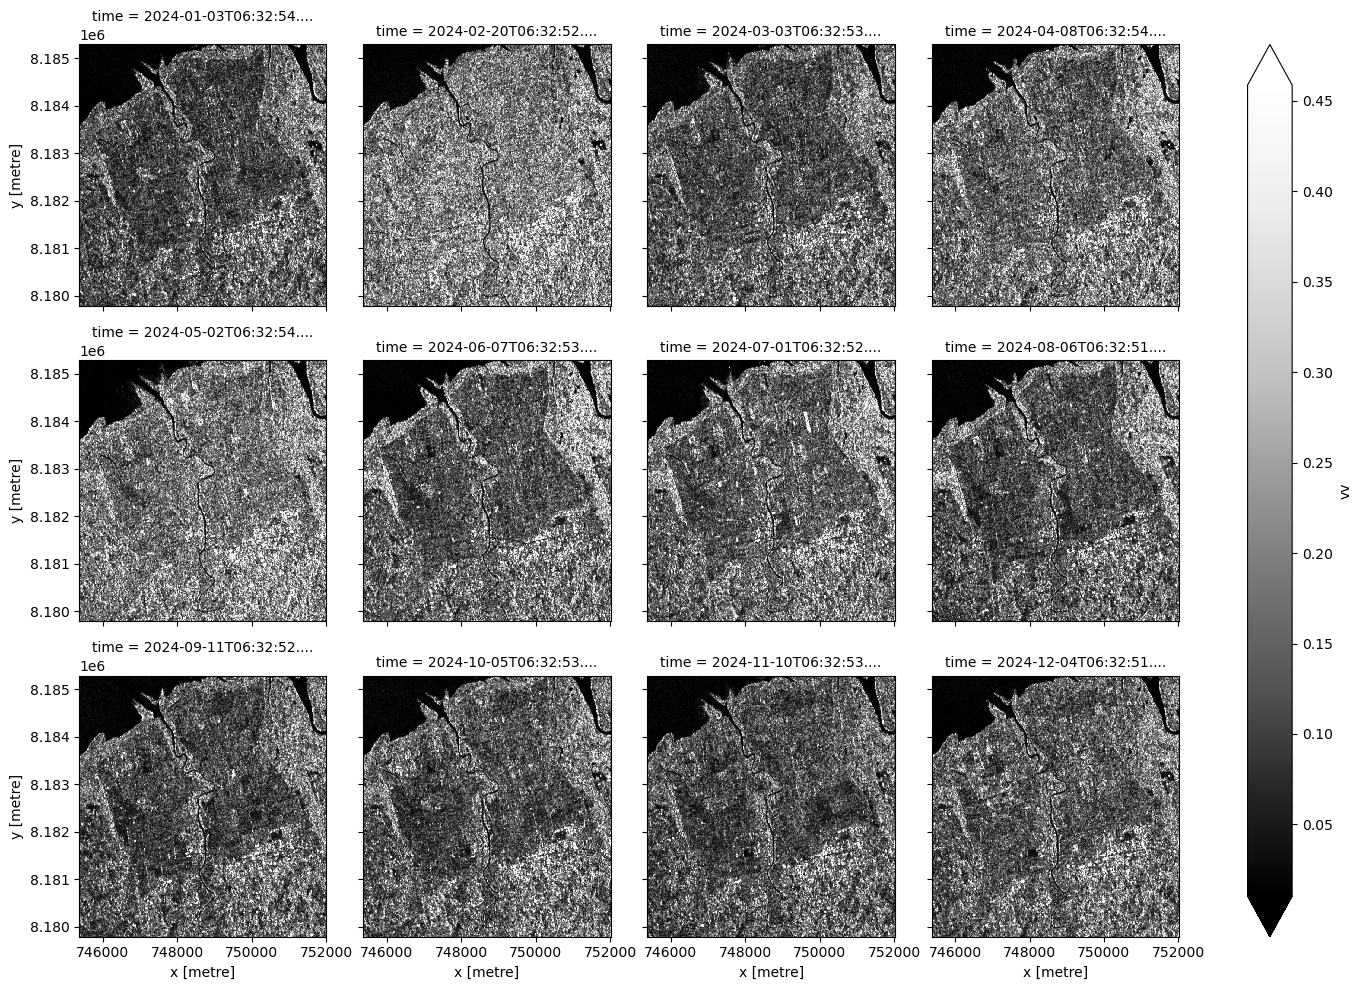

In [90]:
# Convert the time coordinate to pandas datetime
times = pd.to_datetime(data.time.values)

# Convert to monthly periods and get the first index of each unique month
_, unique_month_indices = np.unique(times.to_period("M"), return_index=True)

# Select only one image per month
monthly_data = data.isel(time=unique_month_indices)

# Plot VV polarization (1 image per month)
monthly_data.vv.plot(
    cmap="Greys_r",
    robust=True,
    col="time",
    col_wrap=4,
    figsize=(15, 10)
)

# In this channel, VV (co-pol) polarization it is sensitive in detecting surface scattering such as buldings, urban areas, bareground, etc. Darker areas may indicate flat smooth areas such as bareground, bareland, development or constructed area 
# and brighter areas correlates to buildings or urban areas

#### Plot VH polarisation

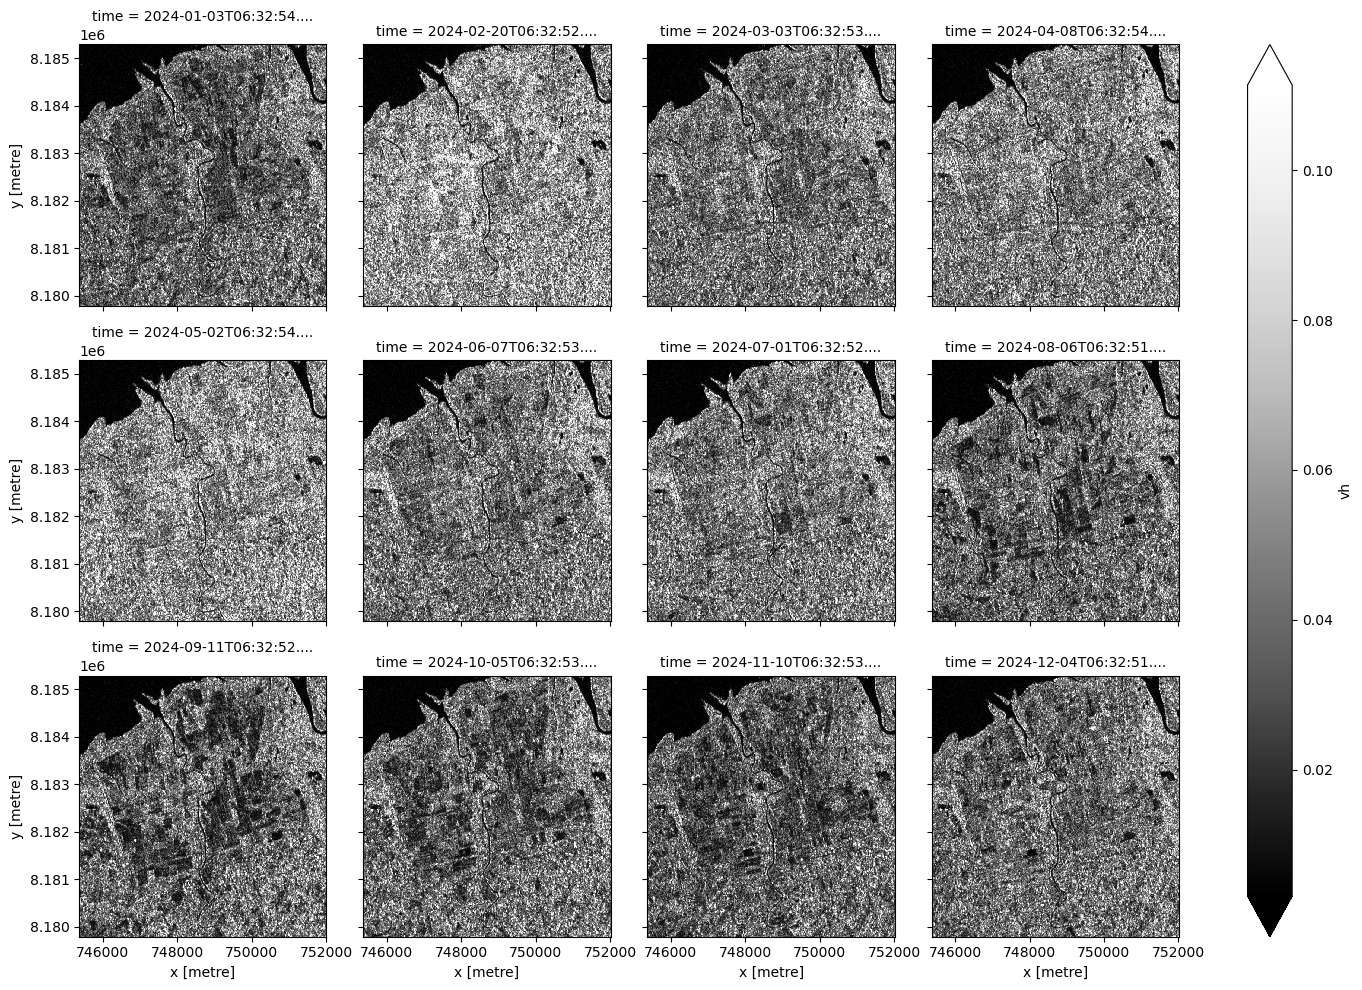

In [91]:
# Convert the time coordinate to pandas datetime
times = pd.to_datetime(data.time.values)

# Convert to monthly periods and get the first index of each unique month
_, unique_month_indices = np.unique(times.to_period("M"), return_index=True)

# Select only one image per month
monthly_data = data.isel(time=unique_month_indices)

# Plot VV polarization (1 image per month)
monthly_data.vh.plot(
    cmap="Greys_r",
    robust=True,
    col="time",
    col_wrap=4,
    figsize=(15, 10)
)

# In this channel, the vh (cross-pol) polariozation, it sensitive in detecting volume scattering where darker areas indicates rock, soil, bareground, water or any smooth surface feature and vegetated areas may appear brighter

Backscatter measurements can be combined in visualization to highlight the different polarization signatures. 
For the RGB visualization below, the ratio between VH and VV is added as a third measurement band.

In [92]:
medians = data.median(dim="time")
scaled = data / medians

In [93]:
# Get monthly indices
times = pd.to_datetime(data.time.values)
_, unique_month_indices = np.unique(times.to_period("M"), return_index=True)

In [94]:
# Select those time steps from scaled data
monthly_scaled = scaled.isel(time=unique_month_indices)

In [96]:
# # Plot scaled VH, VV, and VH/VV as RGB
# monthly_scaled.to_array().plot.imshow(
#     robust=True,
#     col="time",
#     col_wrap=3,
#     figsize=(15, 10)
# )

## Apply speckle filtering

Radar observations appear speckly due to random interference of coherent signals from target scatters. 
The speckle noise can be reduced by averaging pixel values over an area or over time. 
However, averaging over a fixed window smoothes out real local spatial variation and leads to reduced spatial resolution.
An adaptive approach that takes into account local homogeneity is therefore preferred.

Below, we apply the Lee filter, one of the popular adaptive speckle filters.


### Define the Lee Filter Function

In [97]:
# Define a function to apply lee filtering on S1 image 
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    da_notime = da.squeeze()
    img = da_notime.values
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    # Convert numpy array back to xarray, flipping the Y axis
    output = xr.DataArray(img_output, dims=da_notime.dims, coords=da_notime.coords)
    
    return output

# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = np.isfinite(data)
masked = data.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
data["filtered_vv"] = masked.vv.groupby("time").map(lee_filter, size=7)
data["filtered_vh"] = masked.vh.groupby("time").map(lee_filter, size=7)

# Null pixels should remain null
data['filtered_vv'] = data.filtered_vv.where(valid.vv)
data['filtered_vh'] = data.filtered_vh.where(valid.vh)

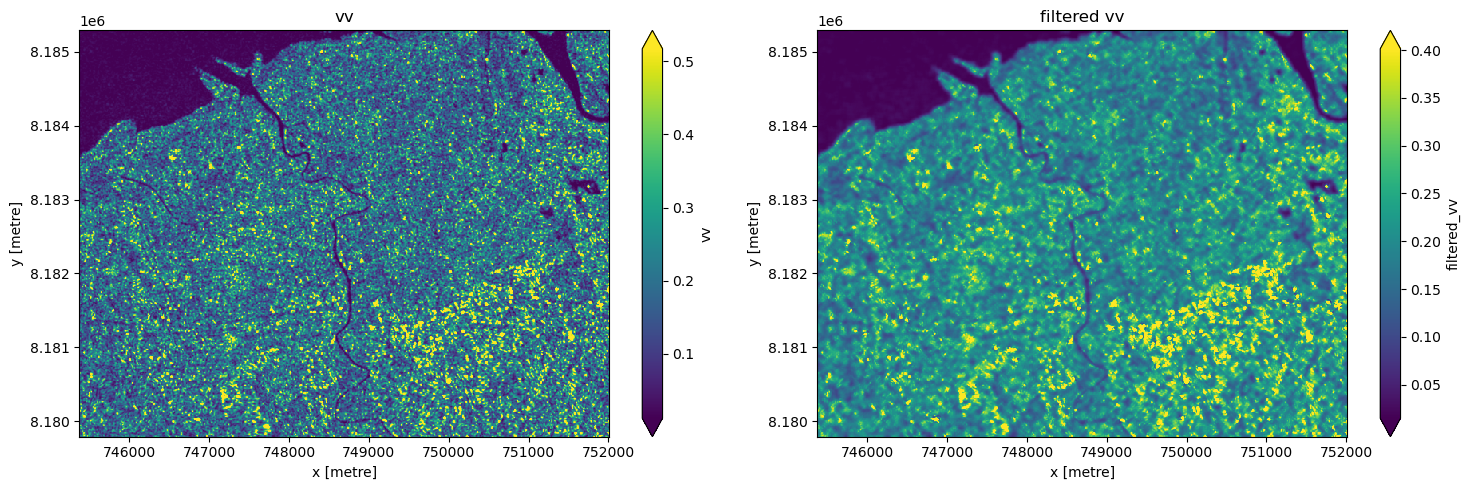

In [98]:
# Images appear smoother after speckle filtering
fig, ax = plt.subplots(1, 2, figsize=(15,5))
data["vv"].isel(time=3).plot(ax = ax[0],robust=True)
data["filtered_vv"].isel(time=3).plot(ax = ax[1],robust=True);
ax[0].set_title('vv')
ax[1].set_title('filtered vv')
plt.tight_layout();

In [ ]:
# import matplotlib.pyplot as plt

# # List of bands to use as RGB (make sure they exist in monthly_scaled)
# rgb_bands = ["filtered_vv", "filtered_vh", "vh/vv"]

# # Loop through each time step and plot RGB
# for i in range(monthly_scaled.time.size):
#     # Extract RGB components for one time step
#     r = monthly_scaled[rgb_bands[0]].isel(time=i)
#     g = monthly_scaled[rgb_bands[1]].isel(time=i)
#     b = monthly_scaled[rgb_bands[2]].isel(time=i)

#     # Stack into (y, x, 3) for imshow
#     rgb = np.stack([r, g, b], axis=-1)

#     # Normalize for display (optional — stretch between 2nd and 98th percentile)
#     p2, p98 = np.percentile(rgb, (2, 98))
#     rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)

#     # Plot
#     plt.figure(figsize=(8, 6))
#     plt.imshow(rgb)
#     date_str = str(monthly_scaled.time.values[i])[:10]
#     plt.title(f"RGB Composite - {date_str}")
#     plt.axis("off")
#     plt.show()


In [21]:
# import numpy as np
# import xarray as xr
# import matplotlib.pyplot as plt
# from scipy.ndimage import uniform_filter

# # Define Lee filter function
# def lee_filter(da, size):
#     """
#     Apply Lee speckle filter with specified window size.
#     Adapted from: https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
#     """
#     da_notime = da.squeeze()
#     img = da_notime.values.astype(np.float32)

#     img_mean = uniform_filter(img, size)
#     img_sqr_mean = uniform_filter(img**2, size)
#     img_variance = img_sqr_mean - img_mean**2

#     overall_variance = np.var(img)
#     img_weights = img_variance / (img_variance + overall_variance)
#     img_output = img_mean + img_weights * (img - img_mean)

#     # Convert numpy array back to xarray
#     output = xr.DataArray(
#         img_output,
#         dims=da_notime.dims,
#         coords=da_notime.coords,
#         attrs=da_notime.attrs
#     )

#     return output

# # Handle nulls: Replace NaNs with 0 for filtering
# masked = data.copy()
# masked["vv"] = xr.DataArray(np.nan_to_num(data.vv), dims=data.vv.dims, coords=data.vv.coords)
# masked["vh"] = xr.DataArray(np.nan_to_num(data.vh), dims=data.vh.dims, coords=data.vh.coords)

# # Apply Lee filter per time step
# data["filtered_vv"] = masked.vv.groupby("time").map(lee_filter, size=7)
# data["filtered_vh"] = masked.vh.groupby("time").map(lee_filter, size=7)

# # Restore original NaN values
# data["filtered_vv"] = data["filtered_vv"].where(np.isfinite(data.vv))
# data["filtered_vh"] = data["filtered_vh"].where(np.isfinite(data.vh))

# # ✅ Visualize original vs filtered for a specific time
# t_idx = 3
# date_str = str(data.time.values[t_idx])[:10]

# fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# data["vv"].isel(time=t_idx).plot(ax=ax[0], robust=True)
# data["filtered_vv"].isel(time=t_idx).plot(ax=ax[1], robust=True)

# ax[0].set_title(f'Original VV ({date_str})')
# ax[1].set_title(f'Filtered VV ({date_str})')
# plt.tight_layout()
# plt.show()


## Compute the radar vegetation index

This study measures the presence of vegetation through either the `Radar vegetation index (RVI)`.
 
The formula is

        RVI = 4*VH/(VV+VH)

RVI is available through the `dualpol_indices` function, imported from [deafrica_tools.bandindices](../Tools/deafrica_tools/bandindices.py).

In [99]:
ds = dualpol_indices(data, index="RVI")

In [100]:
def dualpol_indices(ds, index="RVI"):
    """
    Calculate radar vegetation index (RVI) from VV and VH.

    Parameters:
        ds (xarray.Dataset): Dataset with 'vv' and 'vh' variables.
        index (str): Name of the index to compute (only 'RVI' supported here).

    Returns:
        xarray.Dataset: Dataset with RVI added as a new variable.
    """
    if index == "RVI":
        # Ensure VV and VH are present
        if "vv" in ds and "vh" in ds:
            rvi = (4 * ds["vh"]) / (ds["vv"] + ds["vh"] + 1e-6)  # add small constant to avoid division by zero
            ds["RVI"] = rvi
        else:
            raise ValueError("Dataset must contain 'vv' and 'vh' to compute RVI.")
    else:
        raise ValueError(f"Index {index} not supported.")
    
    return ds

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.  


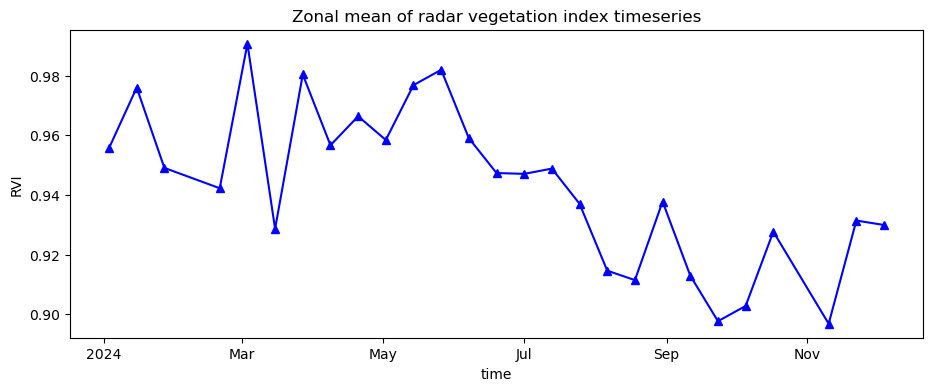

In [101]:
ds.RVI.mean(["x", "y"]).plot.line("b-^", figsize=(11, 4))
plt.title("Zonal mean of radar vegetation index timeseries");

## Smoothing/Interpolating vegetation time-series

Here, we will smooth and interpolate the data to ensure we working with a consistent time-series. This is a very important step in the workflow and there are many ways to smooth, interpolate, gap-fill, remove outliers, or curve-fit the data to ensure a useable time-series. If not using the default example, you may have to define additional methods to those used here.

To do this we take two steps:

1. Resample the data to fortnightly time-steps using the fortnightly median
2. Calculate a rolling mean with a window of 4 steps


In [102]:
resample_period = "2W"
window = 4

rvi_smooth = (
    ds.RVI.resample(time=resample_period)
    .median()
    .rolling(time=window, min_periods=1)
    .mean()
)

Plot the smoothed and interpolated time-series

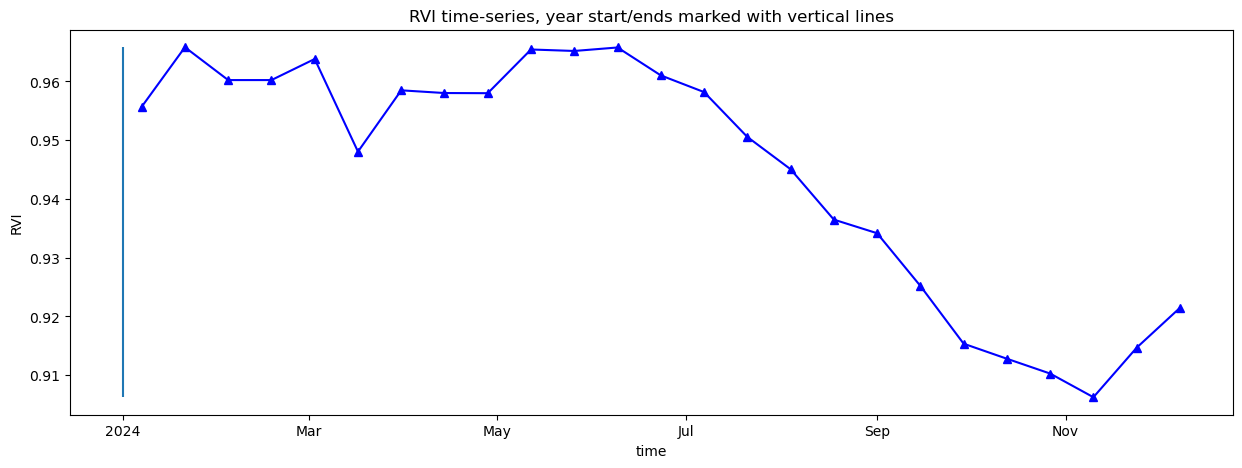

In [113]:
rvi_smooth_1D = rvi_smooth.mean(["x", "y"])
rvi_smooth_1D.plot.line("b-^", figsize=(15, 5))
_max = rvi_smooth_1D.max()
_min = rvi_smooth_1D.min()
# plt.vlines(np.datetime64("2019-01-01"), ymin=_min, ymax=_max)
# plt.vlines(np.datetime64("2020-01-01"), ymin=_min, ymax=_max)
plt.vlines(np.datetime64("2024-01-01"), ymin=_min, ymax=_max)
plt.title("RVI time-series, year start/ends marked with vertical lines")
plt.ylabel("RVI");

## Calculate phenology statistics using `xr_phenology`

The DE Africa function `xr_phenology` can calculate a number of land-surface phenology statistics that together describe the characteristics of a plant's lifecycle.  The function can calculate the following statistics on either a zonal timeseries (like the one above), or on a per-pixel basis:

        SOS = Date of start of season
        POS = Date of peak of season
        EOS = Date of end of season
        vSOS = Value at start of season
        vPOS = Value at peak of season
        vEOS = Value at end of season
        Trough = Minimum value of season
        LOS = Length of season (Days)
        AOS = Amplitude of season (in value units)
        ROG = Rate of greening
        ROS = Rate of senescence

By default the function will return all the statistics as an `xarray.Dataset`, to return only a subset of these statistics pass a list of the desired statistics to the function e.g. `stats=['SOS', 'EOS', 'ROG']`.

See the [deafrica_tools.temporal](../Tools/deafrica_tools/temporal.py) script for more information on each of the parameters in `xr_phenology`.


### Zonal phenology statistics

To help us understand what these statistics refer too, lets first pass the simpler zonal mean (mean of all pixels in the image) time-series to the function and plot the results on the same curves as above.

First, provide a list of statistics to calculate with the parameter, `pheno_stats`.

`method_sos` : If 'first' then vSOS is estimated as the first positive slope on the greening side of the curve. If 'median', then vSOS is estimated as the median value of the postive slopes on the greening side of the curve.

`method_eos` : If 'last' then vEOS is estimated as the last negative slope on the senescing side of the curve. If 'median', then vEOS is estimated as the 'median' value of the negative slopes on the senescing side of the curve.

In [106]:
pheno_stats = [
    "SOS",
    "vSOS",
    "POS",
    "vPOS",
    "EOS",
    "vEOS",
    "Trough",
    "LOS",
    "AOS",
    "ROG",
    "ROS",
]
method_sos = "first"
method_eos = "last"

#### Define xr_phenology function

In [107]:
from temporal import xr_phenology

# find all the years to assist with plotting
years = rvi_smooth_1D.groupby("time.year")

# store results in dict
pheno_results = {}

# loop through years and calculate phenology
for y, year in years:
    # calculate stats
    stats = xr_phenology(
        year,
        method_sos=method_sos,
        method_eos=method_eos,
        stats=pheno_stats,
        verbose=False,
    )
    # add results to dict
    pheno_results[str(y)] = stats

df_dict = {}
for key, value in pheno_results.items():
    df_dict_1 = {}
    for b in value.data_vars:
        if value[b].dtype == np.dtype("<M8[ns]") or value[b].dtype == np.dtype("int16"):
            result = pd.to_datetime(value[b].values)
        else:
            result = round(float(value[b].values), 3)
        df_dict_1[b] = result
    df_dict[key] = df_dict_1
            
df = (pd.DataFrame(df_dict)).T
df

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:246: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


SOS vSOS                  POS   vPOS                  EOS   vEOS Trough  \
2024  NaT  NaN  2024-01-21 00:00:00  0.966  2024-11-10 00:00:00  0.906  0.906   

      LOS   AOS  ROG  ROS  
2024  0.0  0.06  NaN -0.0

Plot the results with our statistcs annotated on the plot

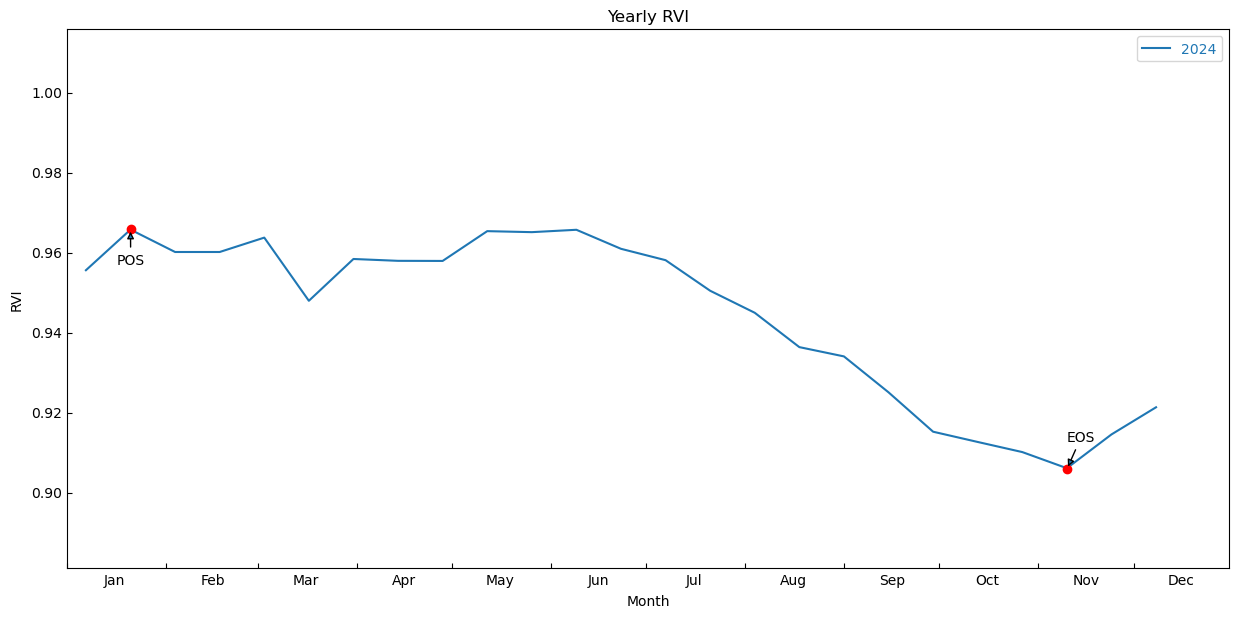

In [108]:
from plotting import xr_animation
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot
import datetime as dt
import matplotlib as mpl

# Figure to which the subplot will be added
fig = plt.figure(figsize=(15, 7))
# Create a subplot that can act as a host to parasitic axes
host = host_subplot(111, figure=fig, axes_class=AA.Axes)


# Function to use to edit the axes of the plot
def adjust_axes(ax):
    # Set the location of the major and minor ticks.
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
    ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=16))

    # Format the major and minor tick labels.
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter("%b"))

    # Turn off unnecessary ticks.
    ax.axis["bottom"].minor_ticks.set_visible(False)

    ax.axis["top"].major_ticks.set_visible(False)
    ax.axis["top"].minor_ticks.set_visible(False)

    ax.axis["right"].major_ticks.set_visible(False)
    ax.axis["right"].minor_ticks.set_visible(False)


# Find all the years to assist with plotting
years = rvi_smooth_1D.groupby("time.year")

# Counter to aid in plotting.
counter = 0

for y, year in years:
    # Grab all the values we need for plotting.
    eos = df.loc[str(y)].EOS
    sos = df.loc[str(y)].SOS
    pos = df.loc[str(y)].POS

    veos = df.loc[str(y)].vEOS
    vsos = df.loc[str(y)].vSOS
    vpos = df.loc[str(y)].vPOS

    if counter == 0:
        ax = host
    else:
        # Create the secondary axis.
        ax = host.twiny()

    # Plot the data
    year.plot(ax=ax, label=y)

    # add start of season
    ax.plot(sos, vsos, "or")
    ax.annotate(
        "SOS",
        xy=(sos, vsos),
        xytext=(-15, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>"),
    )

    # add end of season
    ax.plot(eos, veos, "or")
    ax.annotate(
        "EOS",
        xy=(eos, veos),
        xytext=(0, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>"),
    )

    # add peak of season
    ax.plot(pos, vpos, "or")
    ax.annotate(
        "POS",
        xy=(pos, vpos),
        xytext=(-10, -25),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>"),
    )

    # Set the x-axis limits
    min_x = dt.date(y, 1, 1)
    max_x = dt.date(y, 12, 31)
    ax.set_xlim(min_x, max_x)

    adjust_axes(ax)

    counter += 1

host.legend(labelcolor="linecolor")
host.set_ylim([_min - 0.025, _max.values + 0.05])

plt.xlabel("Month")
plt.ylabel("RVI")
plt.title("Yearly RVI");

## Per-pixel phenology statistics

We can now calculate the statistics for every pixel in our time-series and plot the results.

In [109]:
# find all the years to assist with plotting
years = rvi_smooth.groupby("time.year")

# get list of years in ts to help with looping
years_int = [y[0] for y in years]

# store results in dict
pheno_results = {}

# loop through years and calculate phenology
for year in years_int:
    # select year
    da = dict(years)[year]

    # calculate stats
    stats = xr_phenology(
        da,
        method_sos=method_sos,
        method_eos=method_eos,
        stats=pheno_stats,
        verbose=False,
    )
    # add results to dict
    pheno_results[str(year)] = stats

The phenology statistics have been calculated seperately for every pixel in the image.  Let's plot each of them to see the results. 

Below, pick a year from the phenology results to plot. 

In [110]:
# Pick a year to plot
year_to_plot = "2024"

At the top if the plotting code we re-mask the phenology results with the crop-mask. This is because `xr_phenology`has methods for handling pixels with only NaNs (such as those regions outside of the polygon mask), so the results can have phenology results for regions outside the mask. We will therefore have to mask the data again.

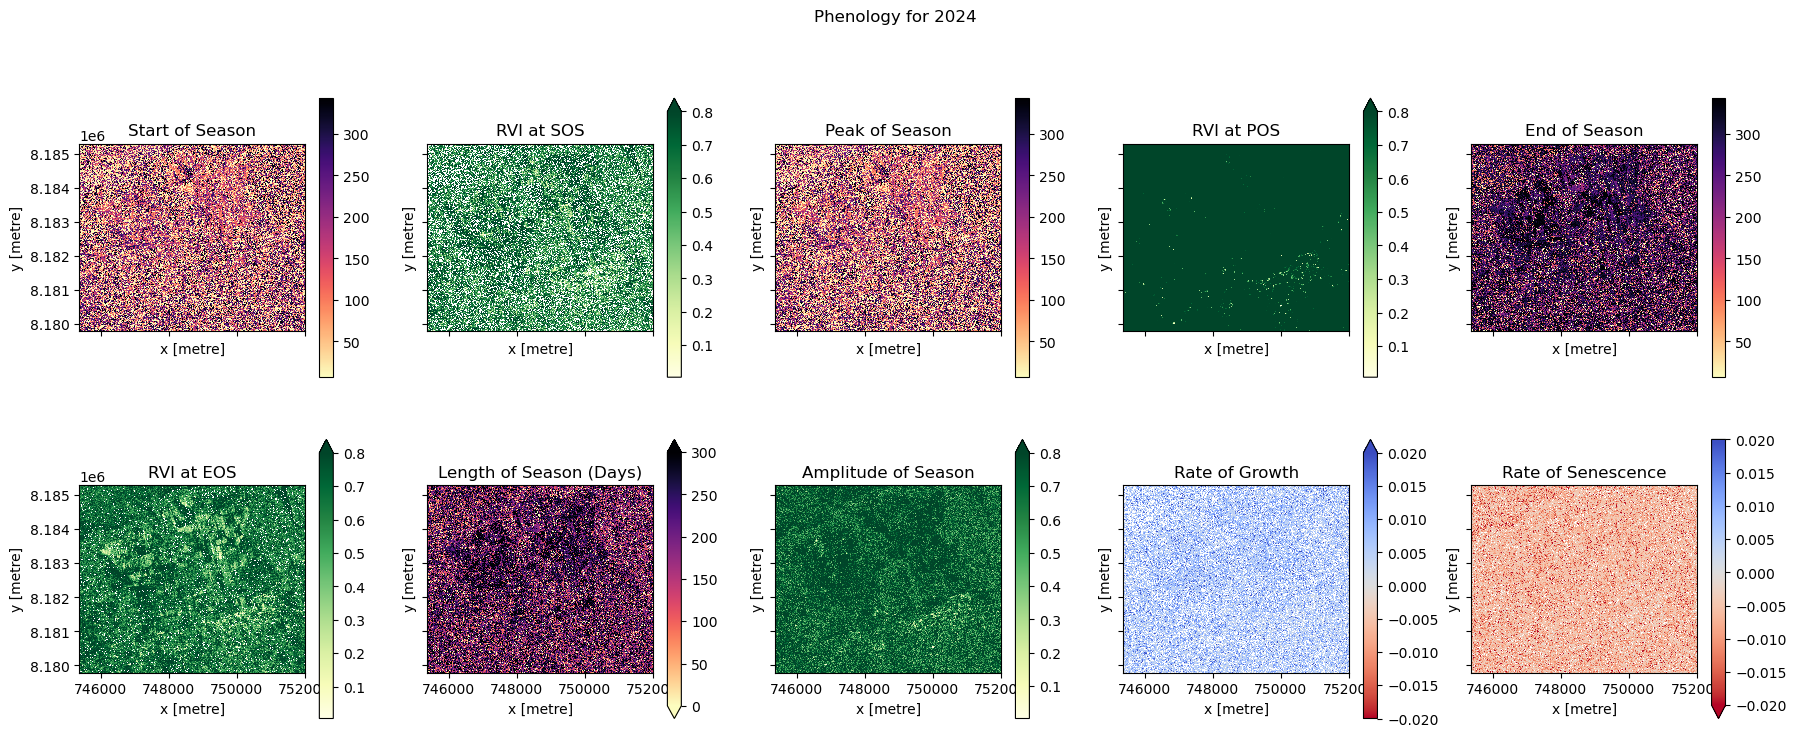

In [111]:
# select the year to plot
phen = pheno_results[year_to_plot]

# Define a few items to aid in plotting.
start_date = dt.date(int(year_to_plot), 1, 1)
end_date = dt.date(int(year_to_plot), 10, 27)

date_list = pd.date_range(start_date, end_date, freq="MS")
bounds = [int(i.strftime("%Y%m%d")) for i in date_list]


@mpl.ticker.FuncFormatter
def float_to_date(x, pos):
    tick_str = str(int(x))
    year = tick_str[:4]
    month = tick_str[4:6]
    day = tick_str[6:]
    return f"{year}-{month}-{day}"


# set up figure
fig, ax = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(18, 8),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.7

# set aspect ratios
for a in fig.axes:
    a.set_aspect("equal")

# start of season
# Convert SOS values from np.date64 to float values for plotting
cax = phen.POS.dt.dayofyear.plot(
    ax=ax[0, 0],
    cmap="magma_r",
    add_colorbar=True,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[0, 0].set_title("Start of Season")

phen.vSOS.plot(ax=ax[0, 1],
               cmap="YlGn",
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title("RVI at SOS")

# peak of season
# # Convert POS values from np.date64 to float values for plotting
cax = phen.POS.dt.dayofyear.plot( 
    ax=ax[0, 2],
    cmap="magma_r",
    add_colorbar=True,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[0, 2].set_title("Peak of Season")

phen.vPOS.plot(ax=ax[0, 3],
               cmap="YlGn",
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 3].set_title("RVI at POS")

# end of season
# Convert EOS values from np.date64 to float values for plotting
cax = phen.EOS.dt.dayofyear.plot(     
    ax=ax[0, 4],
    cmap="magma_r",
    add_colorbar=True,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[0, 4].set_title("End of Season")

phen.vEOS.plot(ax=ax[1, 0],
               cmap="YlGn",
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title("RVI at EOS")

# Length of Season
phen.LOS.plot(
    ax=ax[1, 1],
    cmap="magma_r",
    vmax=300,
    vmin=0,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[1, 1].set_title("Length of Season (Days)")

# Amplitude
phen.AOS.plot(ax=ax[1, 2],
              cmap="YlGn",
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 2].set_title("Amplitude of Season")

# rate of growth
phen.ROG.plot(
    ax=ax[1, 3],
    cmap="coolwarm_r",
    vmin=-0.02,
    vmax=0.02,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[1, 3].set_title("Rate of Growth")

# rate of Sensescence
phen.ROS.plot(
    ax=ax[1, 4],
    cmap="coolwarm_r",
    vmin=-0.02,
    vmax=0.02,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[1, 4].set_title("Rate of Senescence")
plt.suptitle("Phenology for " + year_to_plot)
plt.tight_layout();

## Conclusions

In the example above, we can see most of the fields are following a similar cropping schedule and are therefore likely the same species of crop. We can also observe that some fields have not followed this schedule (e.g. the EOY plot shows some fields didn't follow this schedule, probably because they either remained fallow during the year, or because there were two peaks during the year which may have confused the phenology stats).  Differences in the rates of growth, and in the RVI values at different times of the season, may be attributable to differences in soil quality, watering intensity, or other farming practices. 

Phenology statistics are a powerful way to summarise the seasonal cycle of a plant's life.  Per-pixel plots of phenology can help us understand the timing of vegetation growth and sensecence across large areas and across diverse plant species as every pixel is treated as an independent series of observations. This could be important, for example, if we wanted to assess how the growing seasons are shifting as the climate warms.  
